In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip -q "/content/drive/My Drive/data/tiny-imagenet-200.zip"

In [ ]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.engine.topology import Network
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(121)
tf.random.set_seed(85)

In [ ]:
### Constants ###
DATA_DIR = "/content/tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

In [ ]:
def load_dataset_small(num_images_per_class_train=100, num_images_test=1000):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        #for img_name_i in c_imgs[0:num_images_per_class_train]:
        for img_name_i in c_imgs:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    #for img_name_i in test_imgs[0:num_images_test]:
    for img_name_i in test_imgs:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [ ]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 100000
Number of test examples = 10000
X_train shape: (100000, 64, 64, 3)


In [ ]:
del X_train_orig, X_test_orig

In [ ]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [ ]:
# Block size to fragment the image
block_size = 8
block_in_one_axis =  64 // block_size
total_block = block_in_one_axis * block_in_one_axis

### Model Implementation (Shuffling)

In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(y_true, y_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(y_true - y_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    s_loss = K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):

    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K = Input(shape=(total_block,))
    input_K_concat = Input(shape=(input_size))

    batch_size = tf.shape(input_S)[0]
   
    blocks = tf.image.extract_patches(input_S,sizes=[1,block_size,block_size,1],strides=[1,block_size,block_size,1],rates=[1, 1, 1, 1],padding='VALID')
    blocks = tf.reshape(blocks,[batch_size, total_block, block_size, block_size, 3])

    integer_K = tf.dtypes.cast(input_K, tf.int32)
    i1 = tf.expand_dims(tf.range(batch_size), axis = 1)
    i1 = tf.tile(i1, [1, total_block])
    indices = tf.stack([i1,integer_K], axis=-1)

    scattered = tf.scatter_nd(indices, blocks, (batch_size, total_block, block_size, block_size,3 ))

    scattered_blocks = tf.unstack(scattered, axis =1)
    scattered_tensor_row_wise = [tf.concat(scattered_blocks[i:i+block_in_one_axis], axis = -2) for i in tf.range(0,total_block,block_in_one_axis)]
    x = concatenate(scattered_tensor_row_wise, axis = 1)

    # Key Concatenation
    x = concatenate([x, input_K_concat])


    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(x) #changed
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(x) #changed
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C, input_K, input_K_concat], #changed
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    # Reveal network
    reveal_input = Input(shape=(input_size))
    input_K = Input(shape=(total_block,))
    input_K_concat = Input(shape=(input_size))

    batch_size = tf.shape(reveal_input)[0]
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed

    x = concatenate([input_with_noise, input_K_concat])
    #x = concatenate([input_with_noise, input_K])
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)

    scattered_tensor = x
    blocks = tf.image.extract_patches(scattered_tensor,sizes=[1,block_size,block_size,1],strides=[1,block_size,block_size,1],rates=[1, 1, 1, 1],padding='VALID')
    blocks = tf.reshape(blocks,[batch_size,total_block,block_size,block_size,3])

    integer_K = tf.dtypes.cast(input_K, tf.int32)

    i1 = tf.expand_dims(tf.range(batch_size), axis = 1)
    i1 = tf.tile(i1, [1, total_block])
    indices = tf.stack([i1,integer_K], axis=-1)

    unscattered = tf.gather_nd(blocks,indices)

    unscattered_blocks = tf.unstack(unscattered, axis =1)
    unscattered_tensor_row_wise = [tf.concat(unscattered_blocks[i:i+block_in_one_axis], axis = -2) for i in range(0,total_block,block_in_one_axis)]
    output_Sprime = concatenate(unscattered_tensor_row_wise, axis = 1)

    
    if not fixed:
        return Model(inputs=[reveal_input,input_K, input_K_concat],
                     outputs=output_Sprime,
                     name = 'Decoder')
    # else:
    #     return Container(inputs=reveal_input,
    #                      outputs=output_Sprime,
    #                      name = 'DecoderFixed')                    # Changed
    else:
      return Network(inputs=[reveal_input,input_K, input_K_concat],   #changed
                      outputs=output_Sprime,
                      name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    # Calculations for dividing into blocks

    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size)) 
    input_K = Input(shape=(total_block,))
    input_K_concat = Input(shape=(input_size)) 
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C, input_K, input_K_concat]) #changed
    output_Sprime = decoder([output_Cprime, input_K, input_K_concat]) #changed

    autoencoder = Model(inputs=[input_S, input_C, input_K, input_K_concat],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    return encoder, decoder, autoencoder

### 1st 10 Epoch :

In [ ]:
def Train(e) :
  NB_EPOCHS = e
  BATCH_SIZE = 32
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])

  
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.zeros(shape=(len(batch_S), total_block))
          for i in range(len(batch_S)):
            batch_K[i] = random.sample(range(0, total_block), total_block)

          batch_K_concat = np.random.randint(256, size=(len(batch_S), 64, 64, 3))
          batch_K_concat = batch_K_concat/255.
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K, batch_K_concat])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K, batch_K_concat], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K,batch_K_concat],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE   12114.00 | Loss Rev    8637.23: 100%|██████████| 1563/1563 [08:27<00:00,  3.08it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE    5614.36 | Loss Rev    4231.50: 100%|██████████| 1563/1563 [07:49<00:00,  3.33it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE    4062.29 | Loss Rev    2768.91: 100%|██████████| 1563/1563 [07:48<00:00,  3.34it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE    6355.88 | Loss Rev    4364.14: 100%|██████████| 1563/1563 [07:46<00:00,  3.35it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE    3283.80 | Loss Rev    2069.45: 100%|██████████| 1563/1563 [07:45<00:00,  3.36it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE    2936.70 | Loss Rev    1807.09: 100%|██████████| 1563/1563 [07:42<00:00,  3.38it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE    2837.78 | Loss Rev    1710.66: 100%|██████████| 1563/1563 [07:44<00:00,  3.36it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE    2708.63 | Loss Rev    1604.62: 100%|██████████| 1563/1563 [07:41<00

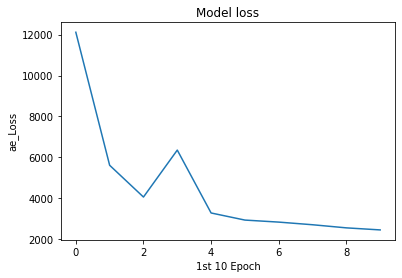

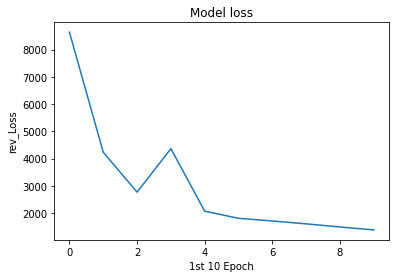

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(10)
autoencoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_autoencoder_model_100k_10e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_encoder_model_100k_10e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_reveal_model_100k_10e.hdf5')

with open('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_autoencoder_100k_10e.txt', 'w') as f:
    for item in ae_loss_history:
        f.write("%s," % item)
with open('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_reveal_100k_10e.txt', 'w') as f:
    for item in rev_loss_history:
        f.write("%s," % item)

plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('1st 10 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('1st 10 Epoch')
plt.show()

### 2nd 10 epochs

In [ ]:
def Train(e) :
  NB_EPOCHS = e
  BATCH_SIZE = 32
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_autoencoder_model_100k_10e.hdf5')
  encoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_encoder_model_100k_10e.hdf5')
  reveal_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_reveal_model_100k_10e.hdf5')

  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.zeros(shape=(len(batch_S), total_block))
          for i in range(len(batch_S)):
            batch_K[i] = random.sample(range(0, total_block), total_block)

          batch_K_concat = np.random.randint(256, size=(len(batch_S), 64, 64, 3))
          batch_K_concat = batch_K_concat/255.
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K, batch_K_concat])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K, batch_K_concat], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K,batch_K_concat],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE    2796.44 | Loss Rev    1611.93: 100%|██████████| 1563/1563 [12:16<00:00,  2.12it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE    2140.57 | Loss Rev    1084.46: 100%|██████████| 1563/1563 [11:37<00:00,  2.24it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE    2022.71 | Loss Rev     971.26: 100%|██████████| 1563/1563 [11:37<00:00,  2.24it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE    1974.59 | Loss Rev     931.11: 100%|██████████| 1563/1563 [11:36<00:00,  2.24it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE    1983.15 | Loss Rev     929.41: 100%|██████████| 1563/1563 [11:37<00:00,  2.24it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE    1907.19 | Loss Rev     885.16: 100%|██████████| 1563/1563 [11:40<00:00,  2.23it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE    1865.02 | Loss Rev     862.52: 100%|██████████| 1563/1563 [11:39<00:00,  2.23it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE    1850.34 | Loss Rev     853.58: 100%|██████████| 1563/1563 [11:45<00

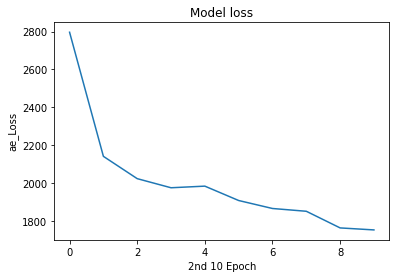

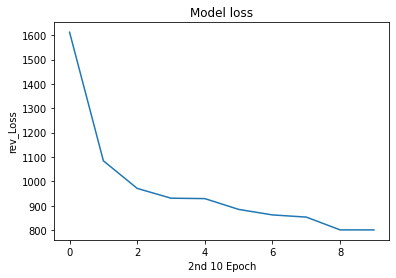

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(10)
autoencoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_autoencoder_model_100k_20e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_encoder_model_100k_20e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_reveal_model_100k_20e.hdf5')

with open('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_autoencoder_100k_20e.txt', 'w') as f:
    for item in ae_loss_history:
        f.write("%s," % item)
with open('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_reveal_100k_20e.txt', 'w') as f:
    for item in rev_loss_history:
        f.write("%s," % item)

plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('2nd 10 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('2nd 10 Epoch')
plt.show()

### 3rd 10 Epoch :

In [ ]:
def Train(e) :
  NB_EPOCHS = e
  BATCH_SIZE = 32
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_autoencoder_model_100k_20e.hdf5')
  encoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_encoder_model_100k_20e.hdf5')
  reveal_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_reveal_model_100k_20e.hdf5')

  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.zeros(shape=(len(batch_S), total_block))
          for i in range(len(batch_S)):
            batch_K[i] = random.sample(range(0, total_block), total_block)

          batch_K_concat = np.random.randint(256, size=(len(batch_S), 64, 64, 3))
          batch_K_concat = batch_K_concat/255.
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K, batch_K_concat])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K, batch_K_concat], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K,batch_K_concat],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE    1816.01 | Loss Rev     867.78: 100%|██████████| 1563/1563 [12:10<00:00,  2.14it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE    1660.97 | Loss Rev     758.50: 100%|██████████| 1563/1563 [11:30<00:00,  2.26it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE    1682.30 | Loss Rev     772.63: 100%|██████████| 1563/1563 [11:28<00:00,  2.27it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE    1639.21 | Loss Rev     754.35: 100%|██████████| 1563/1563 [11:27<00:00,  2.27it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE    1628.50 | Loss Rev     738.46: 100%|██████████| 1563/1563 [11:28<00:00,  2.27it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE    1613.41 | Loss Rev     738.93: 100%|██████████| 1563/1563 [11:28<00:00,  2.27it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE    1546.24 | Loss Rev     701.52: 100%|██████████| 1563/1563 [11:29<00:00,  2.27it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE    1536.96 | Loss Rev     696.79: 100%|██████████| 1563/1563 [11:28<00

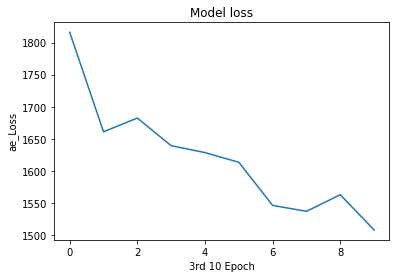

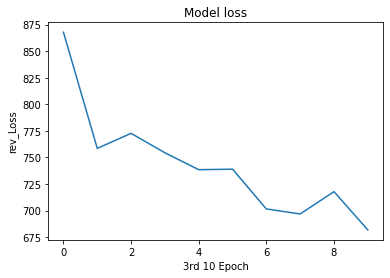

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(10)
autoencoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_autoencoder_model_100k_30e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_encoder_model_100k_30e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_reveal_model_100k_30e.hdf5')

with open('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_autoencoder_100k_30e.txt', 'w') as f:
    for item in ae_loss_history:
        f.write("%s," % item)
with open('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_reveal_100k_30e.txt', 'w') as f:
    for item in rev_loss_history:
        f.write("%s," % item)

plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('3rd 10 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('3rd 10 Epoch')
plt.show()

### 4th 10 Epoch

In [ ]:
def Train(e) :
  NB_EPOCHS = e
  BATCH_SIZE = 32
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_autoencoder_model_100k_30e.hdf5')
  encoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_encoder_model_100k_30e.hdf5')
  reveal_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_reveal_model_100k_30e.hdf5')

  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.zeros(shape=(len(batch_S), total_block))
          for i in range(len(batch_S)):
            batch_K[i] = random.sample(range(0, total_block), total_block)

          batch_K_concat = np.random.randint(256, size=(len(batch_S), 64, 64, 3))
          batch_K_concat = batch_K_concat/255.
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K, batch_K_concat])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K, batch_K_concat], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K,batch_K_concat],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE    1568.80 | Loss Rev     723.80: 100%|██████████| 1563/1563 [12:00<00:00,  2.17it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE    1486.46 | Loss Rev     673.46: 100%|██████████| 1563/1563 [11:24<00:00,  2.28it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE    1492.38 | Loss Rev     681.77: 100%|██████████| 1563/1563 [11:24<00:00,  2.29it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE    1479.31 | Loss Rev     668.80: 100%|██████████| 1563/1563 [11:23<00:00,  2.29it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE    1478.29 | Loss Rev     669.11: 100%|██████████| 1563/1563 [11:24<00:00,  2.28it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE    1456.47 | Loss Rev     661.88: 100%|██████████| 1563/1563 [11:21<00:00,  2.29it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE    1441.11 | Loss Rev     654.71: 100%|██████████| 1563/1563 [11:21<00:00,  2.29it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE    1439.67 | Loss Rev     651.17: 100%|██████████| 1563/1563 [11:21<00

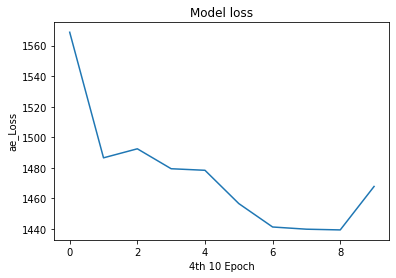

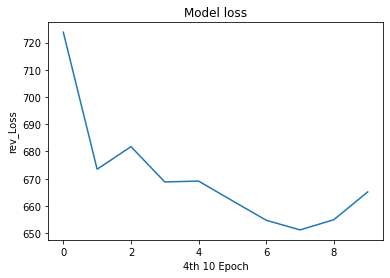

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(10)
autoencoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_autoencoder_model_100k_40e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_encoder_model_100k_40e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_reveal_model_100k_40e.hdf5')

with open('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_autoencoder_100k_40e.txt', 'w') as f:
    for item in ae_loss_history:
        f.write("%s," % item)
with open('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_reveal_100k_40e.txt', 'w') as f:
    for item in rev_loss_history:
        f.write("%s," % item)

plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('4th 10 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('4th 10 Epoch')
plt.show()

### 5th 10 Epoch

In [ ]:
def Train(e) :
  NB_EPOCHS = e
  BATCH_SIZE = 32
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_autoencoder_model_100k_40e.hdf5')
  encoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_encoder_model_100k_40e.hdf5')
  reveal_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_reveal_model_100k_40e.hdf5')

  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.zeros(shape=(len(batch_S), total_block))
          for i in range(len(batch_S)):
            batch_K[i] = random.sample(range(0, total_block), total_block)

          batch_K_concat = np.random.randint(256, size=(len(batch_S), 64, 64, 3))
          batch_K_concat = batch_K_concat/255.
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K, batch_K_concat])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K, batch_K_concat], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K,batch_K_concat],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE    1487.68 | Loss Rev     691.59: 100%|██████████| 1563/1563 [12:15<00:00,  2.13it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE    1401.35 | Loss Rev     634.76: 100%|██████████| 1563/1563 [11:37<00:00,  2.24it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE    1407.31 | Loss Rev     642.21: 100%|██████████| 1563/1563 [11:36<00:00,  2.24it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE    1400.00 | Loss Rev     641.16: 100%|██████████| 1563/1563 [11:35<00:00,  2.25it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE    1398.66 | Loss Rev     641.64: 100%|██████████| 1563/1563 [11:35<00:00,  2.25it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE    1390.67 | Loss Rev     637.38: 100%|██████████| 1563/1563 [11:35<00:00,  2.25it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE    1407.11 | Loss Rev     649.17: 100%|██████████| 1563/1563 [11:35<00:00,  2.25it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE    1380.04 | Loss Rev     634.90: 100%|██████████| 1563/1563 [11:35<00

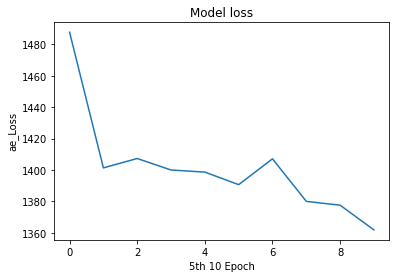

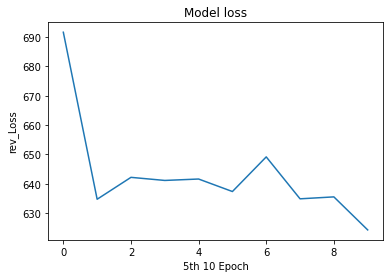

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(10)
autoencoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_autoencoder_model_100k_50e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_encoder_model_100k_50e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_reveal_model_100k_50e.hdf5')

with open('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_autoencoder_100k_50e.txt', 'w') as f:
    for item in ae_loss_history:
        f.write("%s," % item)
with open('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_reveal_100k_50e.txt', 'w') as f:
    for item in rev_loss_history:
        f.write("%s," % item)

plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('5th 10 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('5th 10 Epoch')
plt.show()

### Test 

In [ ]:
# S: secret image
input_S = X_test[0:X_test.shape[0] // 2]

# C: cover image
input_C = X_test[X_test.shape[0] // 2:]

In [ ]:
input_K = np.zeros(shape=(len(input_S), total_block))
for i in range(len(input_S)):
    input_K[i] = random.sample(range(0, total_block), total_block)

In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/eight_block_shuffling/eight_block_shuffling_autoencoder_model_100k_50e.hdf5')
encoder_model.load_weights('/content/drive/My Drive/Final_Model/eight_block_shuffling/eight_block_shuffling_encoder_model_100k_50e.hdf5')
reveal_model.load_weights('/content/drive/My Drive/Final_Model/eight_block_shuffling/eight_block_shuffling_reveal_model_100k_50e.hdf5')

In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    rmse_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    rmse_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return rmse_Spixel, rmse_Cpixel

In [ ]:
decoded = autoencoder_model.predict([input_S, input_C, input_K])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

In [ ]:
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

In [ ]:
tf.reduce_mean(tf.image.ssim(input_S, decoded_S, 1.0))

In [ ]:
tf.reduce_mean(tf.image.ssim(input_C, decoded_C, 1.0))

In [ ]:
tf.reduce_mean(tf.image.psnr(input_S, decoded_S, max_val=1.0))

In [ ]:
tf.reduce_mean(tf.image.psnr(input_C, decoded_C, max_val=1.0))